## Imports

In [2]:
%matplotlib inline
# %pylab inline
import pandas as pd
import sys, os, time, datetime
# import soundfile as sf
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import peakutils
import numpy as np
from matplotlib import mlab
from matplotlib import cm
from matplotlib import animation
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, HTML,Markdown

from tempfile import NamedTemporaryFile


sys.path.append('Libraries')
import signal_processing as spl 
spl = reload(spl)

## Functions to display embeded video

In [3]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim, fps = 5):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=fps, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim, fps = 5):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim, fps))

## File of Raw Recording (.m4a, .wav, whatever)

In [4]:
m4a_file = 'mike_short.m4a'

## Convert to wav file if doesn't exist and read in

rate: 48000
signal length 824256


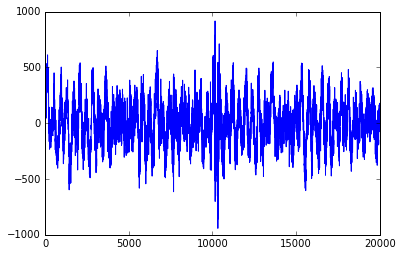

In [5]:
filename, _ = os.path.splitext(m4a_file)
wav_file = filename + '.wav'
if not os.path.exists(wav_file):
    print 'Converting %s to %s' % (m4a_file, wav_file)
    _ = !ffmpeg -i $m4a_file $wav_file
    
(rate,sig) = wav.read(wav_file)
print 'rate:', rate
print 'signal length', len(sig)
pd.Series(sig[:20000]).plot()

## Compute the windowed discrete-time Fourier transform of a signal using a sliding window

Max windows 3679


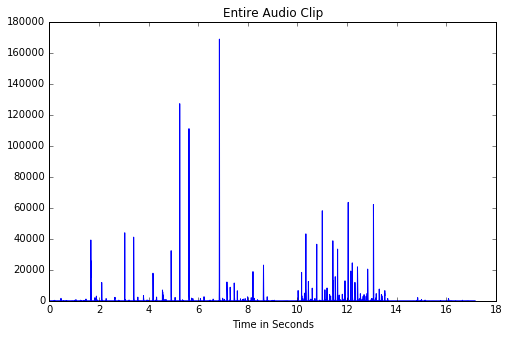

In [6]:
MIN_FREQ = 400 # Minimum frequency to keep in HZ
MAX_FREQ = 12000 # Maximum Frequency to keep in HZ

# Compute the windowed discrete-time Fourier transform of a signal using a sliding window
freqs, t, Pxx = signal.spectrogram(sig, rate)
tN, sN = t[-1], len(sig)

# Limit to MIN_FREQ HZ to MAX_FREQ HZ
Pxx = Pxx[(freqs > MIN_FREQ) & (freqs < MAX_FREQ)]

# Sum over region of frequencies
sum_Pxx = Pxx.sum(axis=0)

print 'Max windows', sum_Pxx.shape[0]

# Plot with peaks detected
_ = plt.figure(figsize = (8,5))
ax = plt.subplot(111)
_ = ax.plot(t, sum_Pxx)
_ = ax.set_xlabel('Time in Seconds')
_ = ax.set_title('Entire Audio Clip')

## Determine Windows in subset of audio

In [13]:
t0, t1 = 1.0, 5. # Min and max timepoint to analyze
min_thresh, max_thresh = 4000, 200000 # min and max threshold for peak detection
MIN_DIST = 20 # Minimum distance between windows

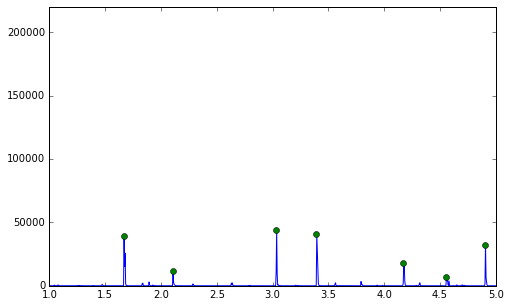

In [14]:
# Take subset of Pxx
ts,te = np.sum(t <= t0), -np.sum(t >= t1)
sum_Pxx_subset = sum_Pxx[ts:te]
t_subset = t[ts:te]

# Take a subset of the time frequency
# PARAMETERS ARE NOT CORRECT, SIMPLY A GOOD ESTIMATION
subset_sound = sig[spl.t_to_ind(t0, tN, sN):spl.t_to_ind(t1, tN, sN)]

# Get indexes withing thresholds
indexes = peakutils.indexes(sum_Pxx_subset, thres=min_thresh / float(sum_Pxx_subset.max()), min_dist=MIN_DIST)
indexes = indexes[sum_Pxx_subset[indexes] < max_thresh]
time_indexes = map(lambda ind : spl.ind_to_t(ind, t_subset[-1], len(sum_Pxx_subset), t0 = t_subset[0]), indexes)

# Plot with peaks detected
_ = plt.figure(figsize = (8,5))
ax = plt.subplot(111)
_ = ax.set_ylim([0, max_thresh*1.1])
_ = ax.plot(t_subset, sum_Pxx_subset)
_ = ax.plot(time_indexes, sum_Pxx_subset[indexes], 'o')

In [15]:
print (t1-t0), 'seconds'

wav.write("subset_sound.wav", rate, subset_sound)
IPython.display.Audio("subset_sound.wav", autoplay=True)

4.0 seconds


In [16]:
fig = plt.figure(figsize = (8,5))
ax = plt.axes(ylim = [0, max_thresh*1.1])
line, = ax.plot(t_subset, sum_Pxx_subset, lw=2)

# _ = ax.plot(sum_Pxx_subset)
# _ = ax.plot(indexes, sum_Pxx_subset[indexes], 'o')

# initialization function: plot the background of each frame
def init():
    return line,

# animation function.  This is called sequentially

ind = 0
next_ind = time_indexes[ind]
def animate(i):
    global ind, next_ind
    
    if t_subset[i] >= next_ind:
        print next_ind,t_subset[i]
        ind +=1
        if ind == len(indexes):
            next_ind = 1e10
        else:
            next_ind = time_indexes[ind]
        ax.axvline(x = t_subset[i], linewidth=3, c = 'r')
    return line,

fps = len(t_subset) / (t_subset[-1] - t_subset[0])
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(t_subset), interval=2, blit=True)

# call our new function to display the animation
display_animation(anim, fps = fps)

1.66788798133 1.66866666667
2.10604278491 2.10733333333
3.03362582653 3.036
3.39253986776 3.39533333333
4.1709638273 4.17466666667
4.55318397511 4.55733333333
4.90277557371 4.90733333333


In [ ]:
len(t_subset) / (t_subset[-1] - t_subset[0])

In [ ]:
mfcc_feat = mfcc(sig,rate)
print 'Shape of mfcc', mfcc_feat.shape